In [1]:
import pandas as pd
import numpy as np
import os, json, requests
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
locations = [(36.8009, 10.1811)]
base_url = r"https://power.larc.nasa.gov/api/temporal/daily/point?parameters=ALLSKY_SFC_SW_DWN&community=RE&longitude={longitude}&latitude={latitude}&start=20170101&end=20230731&format=json"
api_request_url = base_url.format(longitude=10.7843, latitude=35.6563)
response = requests.get(url=api_request_url, verify=True, timeout=30.00)
data = response.json()

In [3]:
data1=data["properties"]["parameter"]
df = pd.DataFrame.from_dict(data1)
df['Datetime']=pd.to_datetime(df.index,format='%Y%m%d')
df.rename(columns={'ALLSKY_SFC_SW_DWN':'Energy'}, inplace=True)
df=df[['Datetime','Energy']]
df.set_index('Datetime', inplace=True)
df

,Energy
Datetime,
2017-01-01,3.16
2017-01-02,3.23
2017-01-03,3.04
2017-01-04,2.70
2017-01-05,2.99
...,...
2023-07-27,7.45
2023-07-28,7.22
2023-07-29,7.38


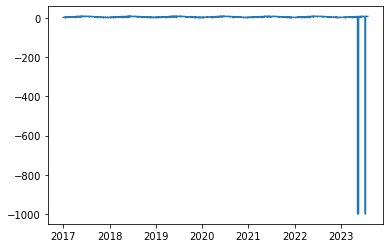

In [4]:
plt.plot(df.Energy)

In [5]:
print(df[2322:2331])
outlier=pd.to_datetime('2023-05-13')
outlier2=pd.to_datetime('2023-05-19')
outlier3=pd.to_datetime('2023-07-13')

df.loc[outlier,'Energy'] = (4.58+5.7)/2
df.loc[outlier2,'Energy'] = (6.92+5.72)/2
print('-------------------------------')
print(df[1227:1236])

            Energy
Datetime          
2023-05-12    4.58
2023-05-13 -999.00
2023-05-14    5.70
2023-05-15    2.41
2023-05-16    6.72
2023-05-17    7.38
2023-05-18    6.92
2023-05-19 -999.00
2023-05-20    5.72
-------------------------------
            Energy
Datetime          
2020-05-12    7.36
2020-05-13    3.36
2020-05-14    5.43
2020-05-15    5.40
2020-05-16    5.64
2020-05-17    5.16
2020-05-18    7.68
2020-05-19    7.01
2020-05-20    7.22


In [6]:
print(df[2383:2386])
df.loc[outlier3,'Energy'] = (7.74+7.94)/2
print('------------')
print(df[2383:2386])

            Energy
Datetime          
2023-07-12    7.74
2023-07-13 -999.00
2023-07-14    7.94
------------
            Energy
Datetime          
2023-07-12    7.74
2023-07-13    7.84
2023-07-14    7.94


In [7]:
df['date2']=df.index
df['date2'] = pd.to_datetime(df['date2'])

In [8]:
monthly_data = df.resample('M', on='date2').sum()
monthly_data = monthly_data.reset_index()
monthly_data.columns = ['Month', 'Total Energy']
monthly_data

,Month,Total Energy
0,2017-01-31,91.87
1,2017-02-28,106.42
2,2017-03-31,165.36
3,2017-04-30,182.68
4,2017-05-31,224.38
...,...,...
74,2023-03-31,163.99
75,2023-04-30,171.10
76,2023-05-31,176.51
77,2023-06-30,209.07


In [9]:
monthly_data['Month']=monthly_data['Month'].dt.strftime('%Y%m')
monthly_data


,Month,Total Energy
0,201701,91.87
1,201702,106.42
2,201703,165.36
3,201704,182.68
4,201705,224.38
...,...,...
74,202303,163.99
75,202304,171.10
76,202305,176.51
77,202306,209.07


In [10]:
monthly_data.set_index('Month',inplace=True)
monthly_data.index = pd.to_datetime(monthly_data.index, format='%Y%m')
monthly_data

,Total Energy
Month,
2017-01-01,91.87
2017-02-01,106.42
2017-03-01,165.36
2017-04-01,182.68
2017-05-01,224.38
...,...
2023-03-01,163.99
2023-04-01,171.10
2023-05-01,176.51


count     79.000000
mean     158.111899
std       54.160711
min       80.340000
25%      101.500000
50%      156.930000
75%      210.225000
max      245.670000
Name: Total Energy, dtype: float64


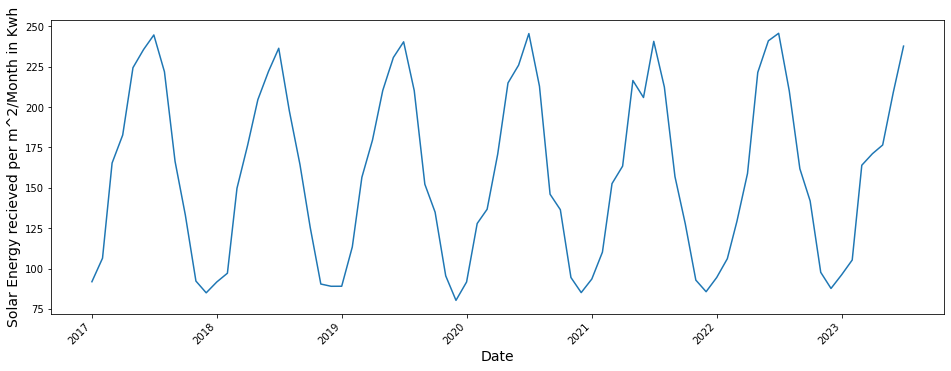

In [11]:
print(monthly_data['Total Energy'].describe())
plt.figure(figsize=(16,6))
plt.xlabel('Date',fontsize=14)
plt.ylabel('Solar Energy recieved per m^2/Month in Kwh',fontsize=14)
plt.gcf().autofmt_xdate(rotation=45)
plt.plot(monthly_data['Total Energy'])

In [12]:
monthly_data.shape

(79, 1)

In [13]:
df_train=monthly_data[:72]
df_test=monthly_data[72:]

C:\Users\malek\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


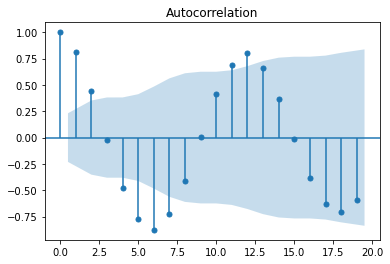

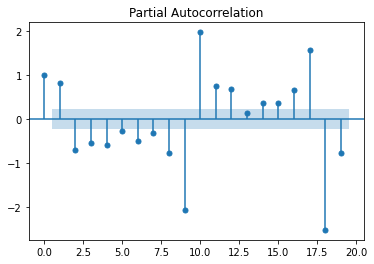

In [14]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

acf = plot_acf(df_train)
pacf= plot_pacf(df_train)

In [15]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
print("p-value : ",adf_test[1])

p-value :  0.08998514190002016


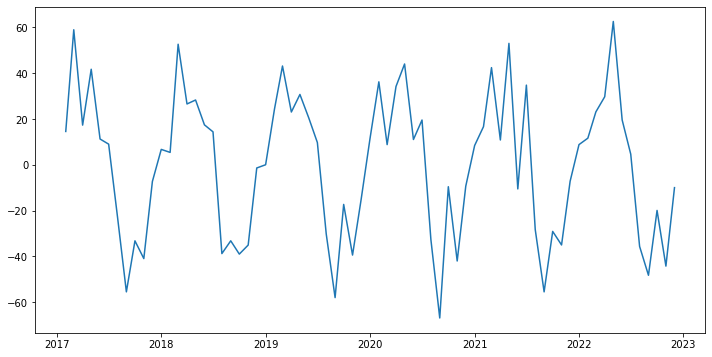

In [16]:
df_train_diff = df_train.diff().dropna()
plt.figure(figsize=(12,6))
plt.plot(df_train_diff)


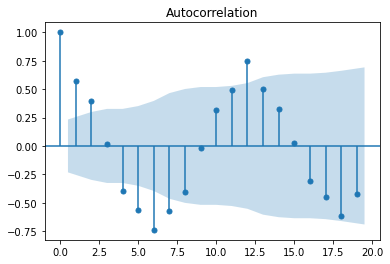

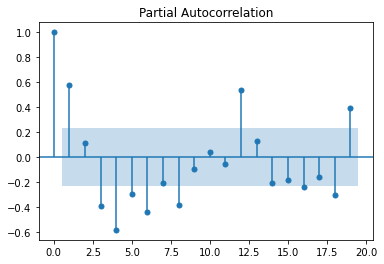

In [17]:
acf_diff = plot_acf(df_train_diff)
pacf_diff = plot_pacf(df_train_diff)

In [18]:
adf_test_diff = adfuller(df_train_diff)
print("p-value : ",adf_test_diff[1])

p-value :  1.7769840789761786e-17


In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(df_train,order=(1,1,1),seasonal_order=(1,1,1,12))

C:\Users\malek\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\malek\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [20]:
model_fit=model.fit()

In [21]:
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       Total Energy   No. Observations:                   72
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -217.948
Date:                            Mon, 21 Aug 2023   AIC                            445.897
Time:                                    07:39:39   BIC                            456.285
Sample:                                01-01-2017   HQIC                           449.952
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0433      0.187      0.231      0.817      -0.324       0.410
ma.L1         -0.8591      0.145   

In [22]:
future_date = pd.DataFrame(pd.date_range(start='2023-07-01', end = '2023-12-01', freq = 'MS'),columns = ['Month'])
future_date.set_index('Month',inplace = True )

<AxesSubplot:>

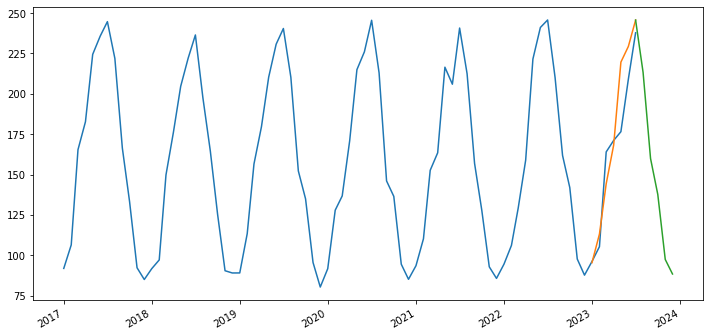

In [23]:
pred = model_fit.forecast(len(df_test))
plt.figure(figsize=(12,6))
plt.plot(monthly_data['Total Energy'])
plt.plot(pred)
pred2 = model_fit.predict(start = future_date.index[0], end = future_date.index[-1])
pred2.plot()

In [24]:
print(pred)
print('-------------------------')
print(df_test)
print('-------------------------')
print(pred2)

2023-01-01     95.419732
2023-02-01    113.117159
2023-03-01    144.240677
2023-04-01    168.236097
2023-05-01    219.585558
2023-06-01    229.310111
2023-07-01    245.600097
Freq: MS, Name: predicted_mean, dtype: float64
-------------------------
            Total Energy
Month                   
2023-01-01         96.15
2023-02-01        105.32
2023-03-01        163.99
2023-04-01        171.10
2023-05-01        176.51
2023-06-01        209.07
2023-07-01        237.73
-------------------------
2023-07-01    245.600097
2023-08-01    213.271421
2023-09-01    159.891362
2023-10-01    137.681151
2023-11-01     97.405777
2023-12-01     88.420809
Freq: MS, Name: predicted_mean, dtype: float64
